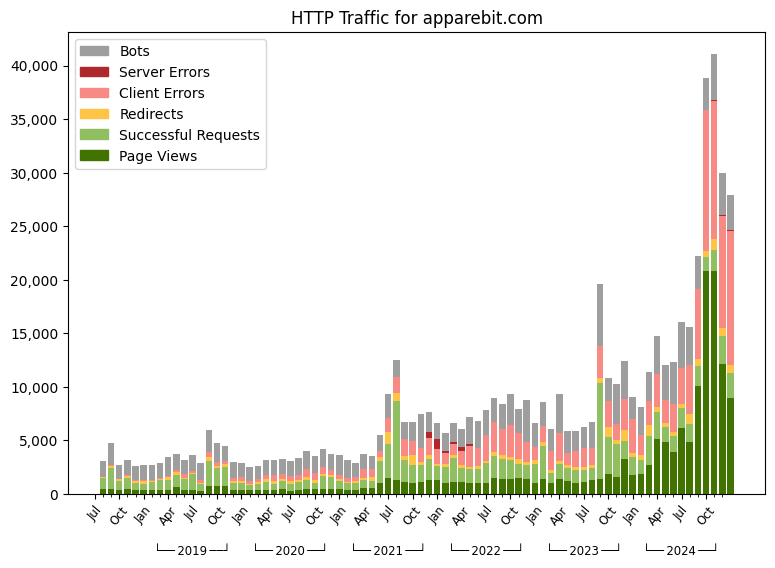

In [1]:
import konsole
konsole.config(level=konsole.WARNING)

from IPython.display import display, HTML
import pandas as pd
import analog
from analog.label import APPAREBIT_COOL_PATHS

frame = analog.latest(root = "data")
analog.validate(frame)
summary = analog.summarize(frame)

display(HTML("<h1>apparebit.com</h1>\n<h2>Monthly Requests</h2>"))
analog.plot_monthly_summary(summary)
None

In [2]:
max_views = summary.data["page_views"].max()
txt = "<h3>Font Licensing</h3>\n<p>"
txt += "✅" if max_views <= 50_000 else "❌"
txt += f" Monthly page views are at most <strong>{max_views:,}</strong>, which is "
if max_views > 50_000:
    txt += "<strong>not</strong>"
txt += "below Bely's license maximum of 50,000."
display(HTML(txt))

In [3]:
def highlights(label, data):
    display(HTML(f"<h2>{label}</h2>\n<h3>Page Rank</h3>"))
    views = data.only.successful().only.humans().only.GET().only.markup()
    known_views = views.only.one_of("cool_path", *APPAREBIT_COOL_PATHS)
    known_views.value_counts("cool_path").show().done()

data = analog.analyze(frame)
highlights("Last Month", data.over.last_month())
highlights("Last Year", data.over.last_year())
highlights("Alltime", data)

,count
cool_path,
/blog/2019/i-feel-love,"6,906"
/,685
/blog/2022/wrong-impression,351
/blog,99
/about/apparebit,76
/blog/2023/great-men,68
/blog/2024/netanyahu-plays-goebbels,54
/blog/2022/zuckerberg-lies,52
/blog/2022/new-map-layers,51


,count
cool_path,
/blog/2019/i-feel-love,"83,507"
/,"7,681"
/blog/2022/wrong-impression,"1,963"
/blog,877
/about/apparebit,790
/blog/2023/great-men,642
/features/esteban,603
/about/robert-grimm,548
/about/privacy,470


,count
cool_path,
/blog/2019/i-feel-love,"89,829"
/,"37,184"
/blog/2022/wrong-impression,"4,520"
/blog,"2,679"
/about/apparebit,"2,615"
/blog/2021/game-of-thrones,"2,410"
/about/privacy,"1,730"
/features/ubu-trump,"1,635"
/about/robert-grimm,"1,603"


In [4]:
views = data.only.successful().only.humans().only.GET().only.markup()
feel_love = views.only.equals("cool_path", "/blog/2019/i-feel-love")

total = len(feel_love.data)
unique = len(feel_love.unique_values("client_address").data)

display(HTML(
    f"""
    <h2>I Feel Love</h2>
    <p>The page had a total of {total:,} views from {unique:,} different IP addresses.
    """
))

# df = pd.DataFrame({"client_address": feel_love.value_counts("client_address").data.head(10).index}).merge(feel_love.data, how="left")
# df["client_city"].drop_duplicates()

0                      None
39758    Generic Smartphone
43065                 Other
Name: device_family, dtype: object